## Key Terms
- **Univariate analysis:**
    Analysis of a single variable in a dataset
- **Multivariate analysis:**
    Analysis that incorporates two or more variables in a dataset
- **Bivariate analysis:**
    A type of multivariate analysis that focuses on exactly two variables
- **Scatter plot:**
    Also called a scattergram, a chart that typically uses dots to represent two numeric variables, with one variable on the x-axis and the other on the y-axis
- **Correlation coefficient:**
    A numeric representation of the linear relationship between two continuous variables
- **Heat map:**
    A type of chart that indicates a variable's magnitude by color variation such as hue or intensity
- **Target variable:**
    Also called the outcome variable, the variable that you're trying to understand or explain

In the previous lesson, you saw how examining individual variables reveals useful insights. But there is more to come!

In data science, many of the interesting insights are discovered when you analyze variables together. For example, the comovement of two variables over time reflects that a common factor may affect these two variables, or that one may affect the other. Or, imagine that you have data about a disease and a hospital's records. If the prevalence of this disease differs significantly among patient age groups, this might be a very important revelation; this implies that age may play an important role in the prevention or treatment of the disease.

Analysis that incorporates two or more variables is called *multivariate analysis*. And in this lesson, you'll explore several multivariate techniques. The figure below shows where this lesson's content fits into the EDA process:

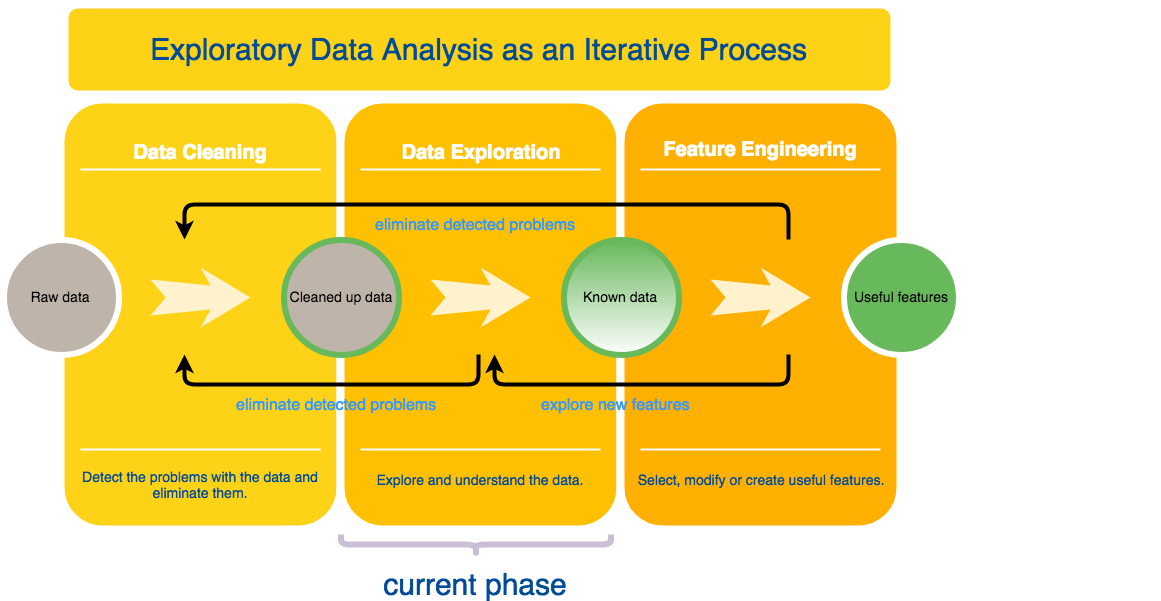

So far in this module, the examples have used the YouTube dataset from Kaggle. In this lesson, you will see some examples from another dataset from Kaggle, called [Students Performance in Exams](https://www.kaggle.com/spscientist/students-performance-in-exams). This dataset consists of information about some student backgrounds and the students' exam results in math, reading, and writing.
    
You'll start by examining pairwise relationships in the data. Analyzing only two variables together is technically called *bivariate analysis*. But bivariate analysis is just a special case of multivariate analysis. Think about the combinations of possible matchings in bivariate analysis with respect to the variable types. You have two types of variables: categorical and continuous. So there are three possible matchings (where order is unimportant): continuous-continuous, continuous-categorical, and categorical-categorical. Each combination requires different analysis, so you'll explore them individually.

## Bivariate analysis of two continuous variables

### Scatter plot

One of the most informative ways of looking at the relationship between two continuous variables is to draw a *scatter plot* (also known as a *scattergram*). For example, if you see that the first variable's value usually goes up when the second one goes up, then this indicates a positive relationship.

Use the following code to take a look at this using the YouTube dataset:

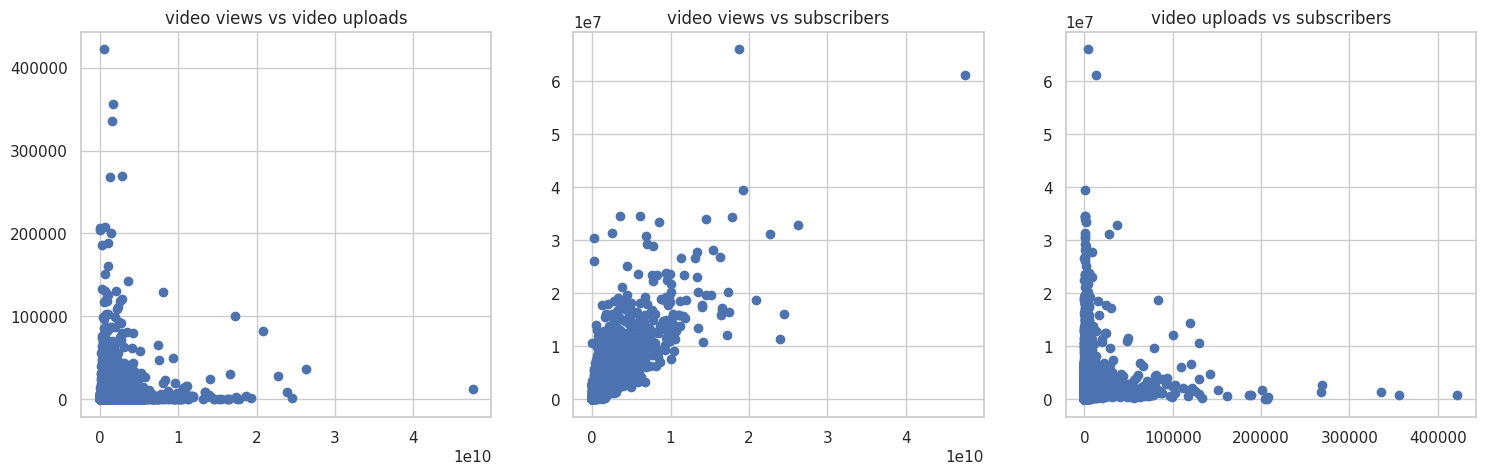

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine, text
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'youtube'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

# youtube_df = pd.read_sql_query('select * from youtube',con=engine)
with engine.begin() as conn:
    query = text("""SELECT * FROM youtube""")
    youtube_df = pd.read_sql_query(query, conn)

# No need for an open connection,
# because you're only doing a single query
engine.dispose()

# You're dealing with the missing values

youtube_df["Video Uploads"] = youtube_df["Video Uploads"].apply(str.strip).replace("--", np.nan)
youtube_df["Video Uploads"] = pd.to_numeric(youtube_df["Video Uploads"], downcast="float")

youtube_df["Subscribers"] = youtube_df["Subscribers"].apply(str.strip).replace("--", np.nan)
youtube_df["Subscribers"] = pd.to_numeric(youtube_df["Subscribers"], downcast="float")

youtube_df.Grade = youtube_df.Grade.apply(str.strip).replace("", np.nan)


youtube_df["Video Uploads"].fillna(youtube_df["Video Uploads"].mean(), inplace=True)
youtube_df["Subscribers"].fillna(youtube_df["Subscribers"].mean(), inplace=True)


# Apply one-way winsorization to the highest end
# of the value distribution. Because you have a lot of extreme
# values, set the values of the outliers to the
# value of the ninetieth percentile.
youtube_df["winsorized_uploads"] = winsorize(youtube_df["Video Uploads"], (0, 0.10))
youtube_df["winsorized_subscribers"] = winsorize(youtube_df["Subscribers"], (0, 0.10))
youtube_df["winsorized_views"] = winsorize(youtube_df["Video views"], (0, 0.10))

for i in range(0, len(youtube_df.Grade)):
    if pd.isnull(youtube_df.Grade[i]):
        youtube_df.Grade[i] = youtube_df.Grade[i-1]

plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.scatter(youtube_df["Video views"], youtube_df["Video Uploads"])
plt.title("video views vs video uploads")

plt.subplot(1,3,2)
plt.scatter(youtube_df["Video views"], youtube_df["Subscribers"])
plt.title("video views vs subscribers")

plt.subplot(1,3,3)
plt.scatter(youtube_df["Video Uploads"], youtube_df["Subscribers"])
plt.title("video uploads vs subscribers")

plt.show()

In the second scatter plot, you can see a positive relationship between the video views and the number of subscribers. Now, examine the relationship between different pairs of student test scores:

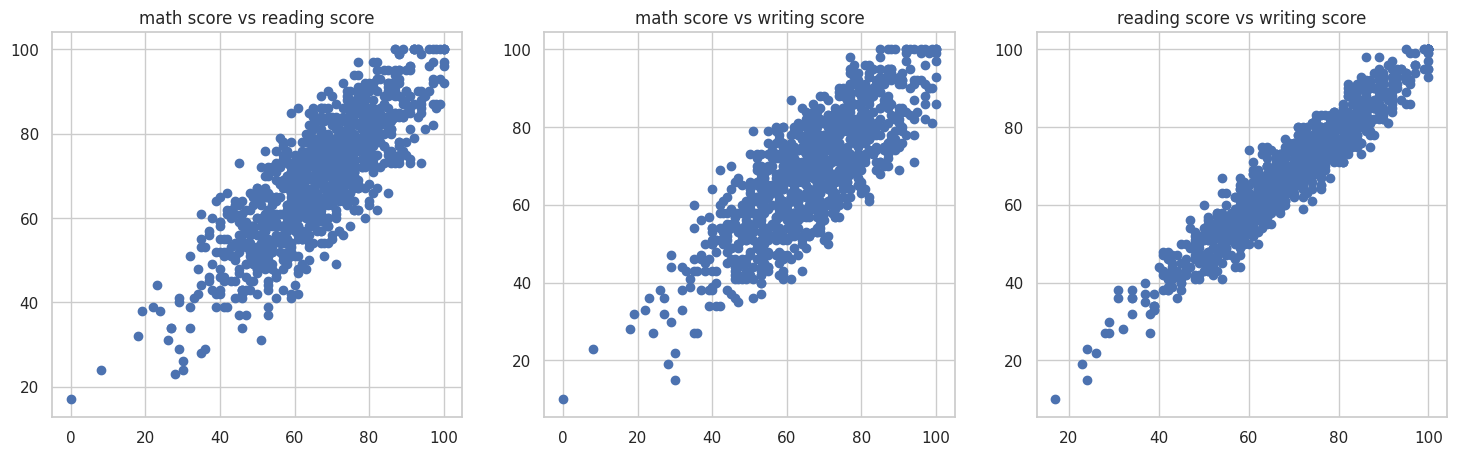

In [4]:
postgres_db = 'studentsperformance'

engine2 = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

# student_df = pd.read_sql_query('select * from studentsperformance',con=engine2)
with engine2.begin() as conn:
    query = text("""SELECT * FROM studentsperformance""")
    student_df = pd.read_sql_query(query, conn)

# No need for an open connection,
# because you're only doing a single query
engine2.dispose()

plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.scatter(student_df["math score"], student_df["reading score"])
plt.title("math score vs reading score")

plt.subplot(1,3,2)
plt.scatter(student_df["math score"], student_df["writing score"])
plt.title("math score vs writing score")

plt.subplot(1,3,3)
plt.scatter(student_df["reading score"], student_df["writing score"])
plt.title("reading score vs writing score")

plt.show()

It appears that success isn't due to chance, but rather to hard work or general intelligence. As you can see, there are positive relationships between all the score types.

**Note:** Recall the lesson on outliers, where you separately looked at extreme values for each variable. There is also another type of outlier, called a *two-dimensional outlier*, that represents unusual *combinations* of values. If you carefully examine the scatter plots above, you may notice some of those unusual value pairs. To deal with these, you can apply one of the techniques described in the outliers lesson.

### Correlation coefficient

Another informative statistic that measures the comovements of two continuous variables is the *correlation coefficient*. The correlation coefficient ($r$) is a numeric representation of the linear relationship between two continuous variables. Correlations range from `-1` to `1`. A correlation coefficient of `-1` indicates a perfect negative relationship: as values in one variable go up, values in the other go down. A correlation coefficient of `0` indicates no relationship between the variables. And a correlation coefficient of `1` indicates a perfect positive relationship: as values in one variable go up, values in the other go up as well.

What you observed in the scatter plots is actually a visual representation of the correlations between variables. Using a number that is indexed between `-1` and `1` adds a layer of precision and ease of interpretation across items.

The `corr()` function from pandas can derive the correlation coefficients across all continuous features in a DataFrame. Now, apply this function to both the YouTube and the student performance datasets:

In [5]:
# Get correlation matrix
youtube_df.corr()

,Video Uploads,Subscribers,Video views,winsorized_uploads,winsorized_subscribers,winsorized_views
Video Uploads,1.000000,0.011329,0.092423,0.473634,0.012593,0.134971
Subscribers,0.011329,1.000000,0.784449,0.082880,0.778046,0.626605
Video views,0.092423,0.784449,1.000000,0.219291,0.578920,0.700070
winsorized_uploads,0.473634,0.082880,0.219291,1.000000,0.097699,0.307744
winsorized_subscribers,0.012593,0.778046,0.578920,0.097699,1.000000,0.743256
winsorized_views,0.134971,0.626605,0.700070,0.307744,0.743256,1.000000


In [6]:
# Get correlation matrix
student_df.corr()

,math score,reading score,writing score
math score,1.000000,0.817580,0.802642
reading score,0.817580,1.000000,0.954598
writing score,0.802642,0.954598,1.000000


In the outputs above, you can see that the correlation between video views and subscribers is around 0.78. And you can see that the correlation between the reading and writing scores is higher than any other combination.

Another convenient way to look at the correlations is to render the matrix as a *heat map*. This combines the effectiveness of visualizations and the precision of statistics. This technique is especially useful if you have a lot of variables in the dataset. Draw correlation matrices for both of your datasets as heat maps using seaborn, as shown in the code below. Note that lighter colors indicate a higher correlation between variables.

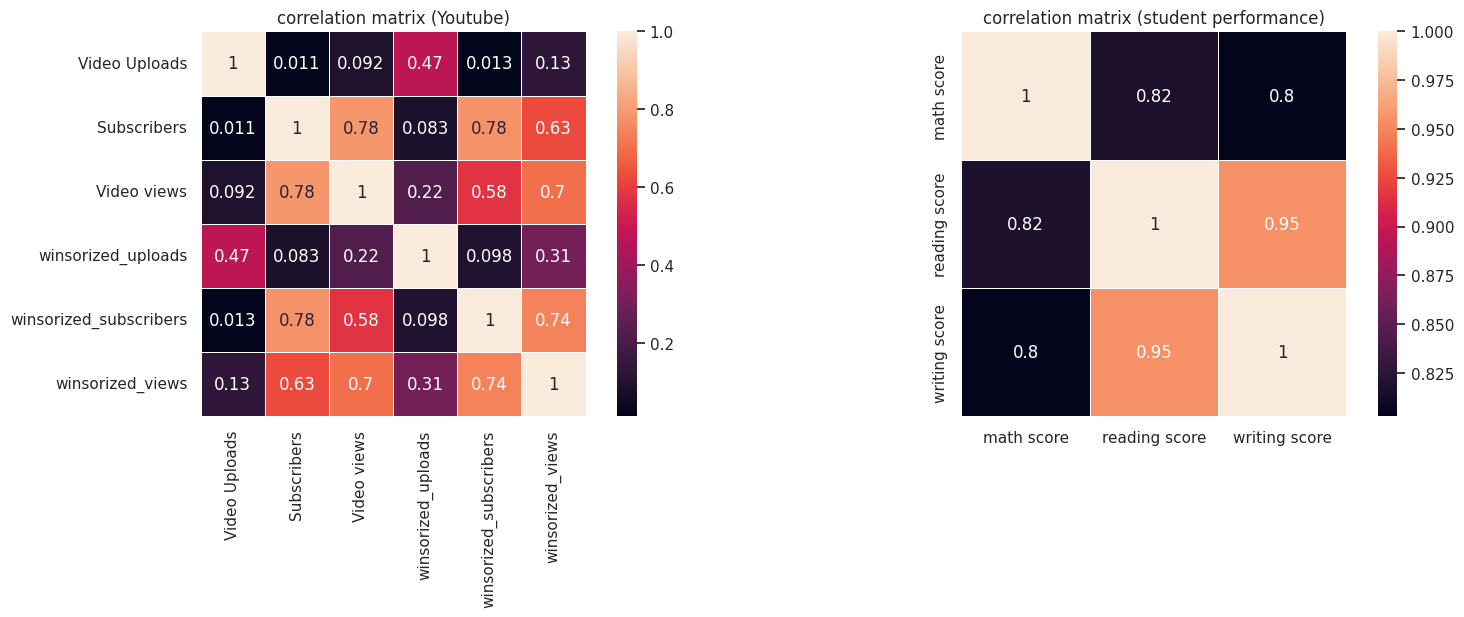

In [7]:
# Make the correlation matrices
corrmat_youtube = youtube_df.corr()
corrmat_student = student_df.corr()

# Heat maps are a great way to get a quick visual read on a big correlation matrix.

plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
# Draw the heat map using seaborn
sns.heatmap(corrmat_youtube, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (Youtube)")

plt.subplot(1,2,2)
# Draw the heat map using seaborn
sns.heatmap(corrmat_student, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (student performance)")

plt.show()

# Try to match the correlation numbers to the scatter plots above to get a
# sense of what each magnitude of correlation can look like.



## Bivariate analysis of a continuous-categorical pair

When you analyze a continuous and a categorical variable pair, you'll usually look at some metric of the continuous variable for each value of the categorical variable. If you observe different values across categories, that implies that the categorical variable has some important information regarding the continuous variable.

One way to look at this is to use the pandas `groupby()` function, using the categorical variable as the grouping variable. After calling this function, you can call some aggregation function like `mean()` or `count()` to derive metrics for the continuous variable by group. Try this out in the YouTube dataset, using the `Grade` variable as the categorical variable:

In [8]:
# Derive averages by group
youtube_df.groupby("Grade").mean()

,Video Uploads,Subscribers,Video views,winsorized_uploads,winsorized_subscribers,winsorized_views
Grade,,,,,,
A,5353.923340,4.931877e+06,2.356715e+09,1675.311768,3.398754e+06,1.447002e+09
A+,16547.927734,1.150483e+07,6.053121e+09,2729.877930,5.061679e+06,2.088445e+09
A++,37450.699219,2.228176e+07,2.119909e+10,4673.700195,5.590006e+06,2.468241e+09
A-,4136.514648,2.784051e+06,1.041149e+09,1319.476562,2.329109e+06,8.810693e+08
B+,2987.168701,1.620059e+06,5.259158e+08,1120.130615,1.513429e+06,5.085668e+08


As you can see, there are substantial differences in the means of the variables across grade groups. Instead of looking at a single metric like the mean, you could also call the `describe()` function after `groupby()`. Although useful, it can be tedious to analyze the resulting table for datasets that contain many continuous variables.

You can also use visualization to assist in analyzing continuous and categorical variable pairs. You can use box plots, bar plots, or other plots to visualize differences in the continuous variable across the groups of the categorical variable.

Begin with bar plots:

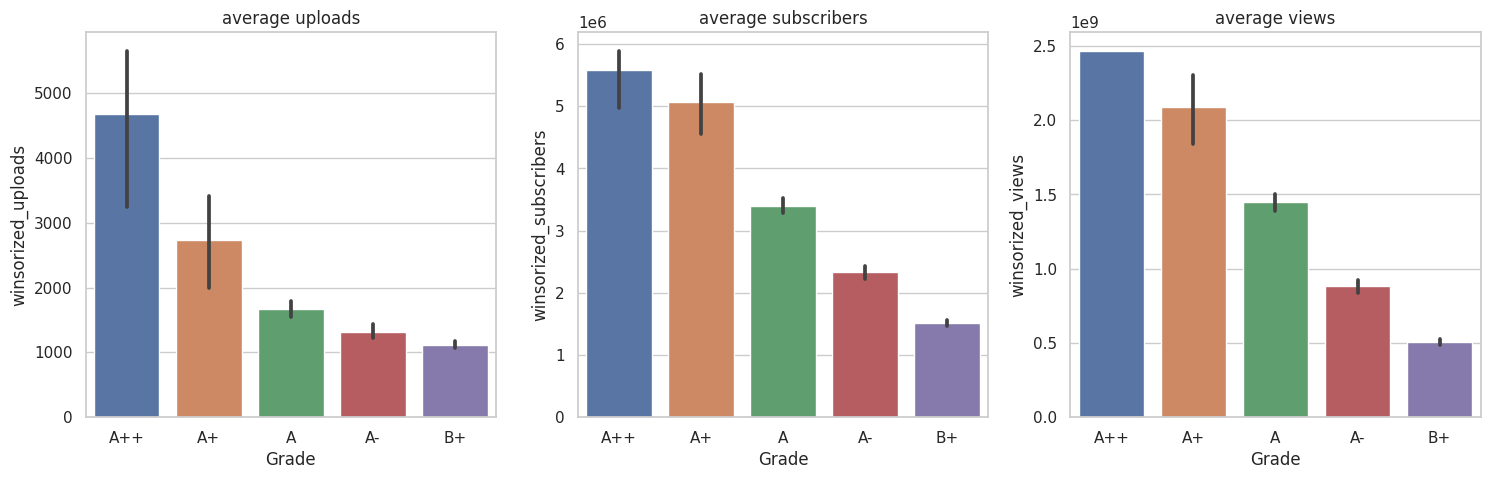

In [11]:
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
sns.barplot(x=youtube_df["Grade"], y=youtube_df["winsorized_uploads"])
plt.title("average uploads")

plt.subplot(1,3,2)
sns.barplot(x=youtube_df["Grade"], y=youtube_df["winsorized_subscribers"])
plt.title("average subscribers")

plt.subplot(1,3,3)
sns.barplot(x=youtube_df["Grade"], y=youtube_df["winsorized_views"])
plt.title("average views")

plt.show()

As you can see, averages decrease as the grade lowers. But keep in mind that visualizing differences is not a formal way of determining that there are significant differences across categories. For this, you need to use a proper statistical test, such as a t-test or ANOVA. So, use the t-test to learn whether the differences are statistically significant.

In [12]:
# Test whether group differences are significant
grades = youtube_df["Grade"].unique()
grouped_df = youtube_df.groupby("Grade")
for var in ["winsorized_uploads", "winsorized_subscribers", "winsorized_views"]:
    print("------------------------------------------------")
    print("Comparisons for variable: {}".format(var))
    print("------------------------------------------------")
    for i in range(0, len(grades)):
        for j in range(i+1, len(grades)):
            print("t-test between groups {0} and {1}:".format(grades[i], grades[j]))
            print(stats.ttest_ind(
                youtube_df[youtube_df["Grade"]==grades[i]][var],
                youtube_df[youtube_df["Grade"]==grades[j]][var]
            ))

------------------------------------------------
Comparisons for variable: winsorized_uploads
------------------------------------------------
t-test between groups A++ and A+:
TtestResult(statistic=2.3701079295583667, pvalue=0.021763511217504406, df=49.0)
t-test between groups A++ and A:
TtestResult(statistic=4.635430672172307, pvalue=4.04691071151326e-06, df=973.0)
t-test between groups A++ and A-:
TtestResult(statistic=5.849570837371606, pvalue=6.6104304190241e-09, df=1032.0)
t-test between groups A++ and B+:
TtestResult(statistic=6.895263692847422, pvalue=6.5424222802511025e-12, df=2968.0)
t-test between groups A+ and A:
TtestResult(statistic=3.226986409425753, pvalue=0.0012914864074672196, df=1004.0)
t-test between groups A+ and A-:
TtestResult(statistic=4.847071427366421, pvalue=1.4393741556097738e-06, df=1063.0)
t-test between groups A+ and B+:
TtestResult(statistic=6.250454036814254, pvalue=4.672654359275399e-10, df=2999.0)
t-test between groups A and A-:
TtestResult(statistic=

The t-tests indicate that some differences are statistically significant and some are not.

## Bivariate analysis of two categorical variables

The last combination remaining is the pair of two categorical variables. Because categorical variables take a limited number of different values by definition, the most common technique used is the observation count of all value pairs. The pandas `crosstab()` function does this for you. Use it on the student performance dataset:

In [13]:
# Print the first few observations
student_df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [14]:
# Create crosstab of gender by race/ethnicity
count_table = pd.crosstab(student_df["gender"], student_df["race/ethnicity"])
count_table

race/ethnicity,group A,group B,group C,group D,group E
gender,,,,,
female,36,104,180,129,69
male,53,86,139,133,71


As you have seen, a visualization can help emphasize the differences between groups. A bar plot where the height of each bar indicates the number of data points in each combination of variables conveys the crosstab's information:

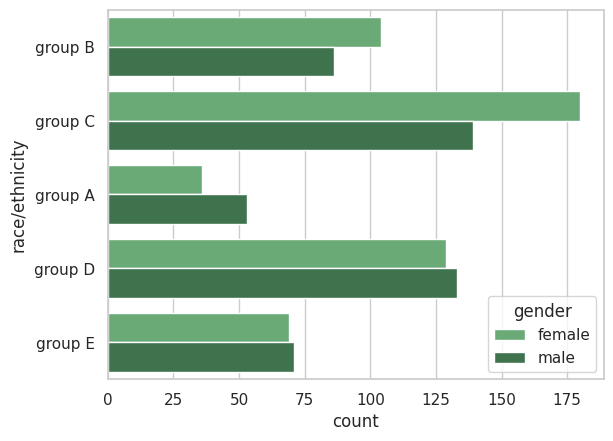

In [15]:
# Plot counts for each combination of levels.
sns.countplot(y="race/ethnicity", hue="gender", data=student_df, palette="Greens_d")
plt.show()

As a reminder, don't forget that the differences that you see above should be checked using formal statistical tests. For this purpose, you can use the *chi-squared test*, which indicates whether one combination of variables is significantly different than the rest:

In [16]:
# This test will return a chi-square test statistic and a p-value. Like the t-test,
# the chi-square test is compared against a distribution (the chi-square
# distribution) to determine whether the group size differences are large
# enough to reflect differences in the population.
print(stats.chisquare(count_table, axis=None))

Power_divergenceResult(statistic=181.70000000000002, pvalue=2.237210012745866e-34)


It seems that the differences are statistically significant.

**Note:** Similar to the way that unusual two-dimensional data points could skew your analysis, groups with very small variances relative to other groups and groups with a very small number of observations can also be misleading. So keep in mind that you should proceed cautiously when you're interpreting the differences for small groups.

## Putting the target at the center

Throughout this lesson, the discussion has stayed fairly general; you haven't focused on any single variable. However, in a real-life data science project, you will put special emphasis on a single variable. This single most important variable is the one that you're trying to understand and explain. This variable is called the *target variable* or *outcome variable*.

Consider the YouTube dataset. Imagine that your goal is to predict the video views for a channel, because that will help you guess how much money a channel makes from YouTube. In this case, your target variable becomes `Video views`. You want to understand whether the other variables in your dataset have some information to help you predict the number of views. In this example, your target variable is continuous. And in your bivariate analysis, you can look at the correlation coefficients of `Video views` with respect to other continuous variables to get a sense of how much other variables are related to your target. If your target were a categorical variable, then you would apply other techniques to explore the relationship of your target to the other variables.

Hence, your target variable should be located at the center of your exploratory data analysis.

That said, this doesn't mean that a multivariate analysis should include *only* the target variable. It's also useful to understand the relationships between the variables other than the target variable. As you'll see in the next lesson, one objective of a data science project is to feed your model as few variables as possible, while losing as little information as possible. Of course, this is a trade-off, and you can strike a balance by detecting features that are least useful in the presence of the other features.

**Note:** You'll only have a single target in most data science projects. But in some cases, having multiple targets is also possible. It's important that you're aware of this fact, but you won't explore it further in this program. Cases with multiple target variables are rare and usually require advanced techniques that are beyond the scope of this program.